In [1]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

def plot_value_function(V, title="Value Function"):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation state as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn
def create_greedy_action_policy(env,Q):
    """ Create greedy action policy
    Args:
        env: Environment
        Q: Q table
    
    Returns:
        Greedy-action Policy function 
    """
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy

def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: Environment.
        num_episodes: Number of episodes to sample.
        policy: The policy to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy 
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula 
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [4]:
env = gym.make('Blackjack-v0')
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 500000, rand,0.9)

Episode 500000/500000.

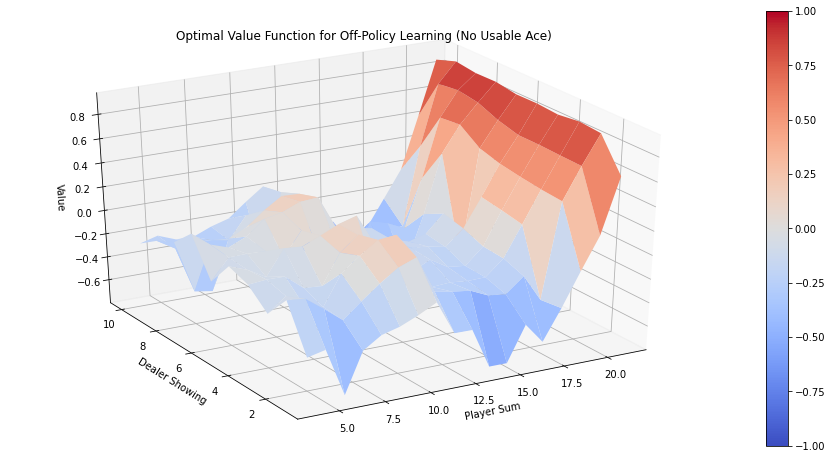

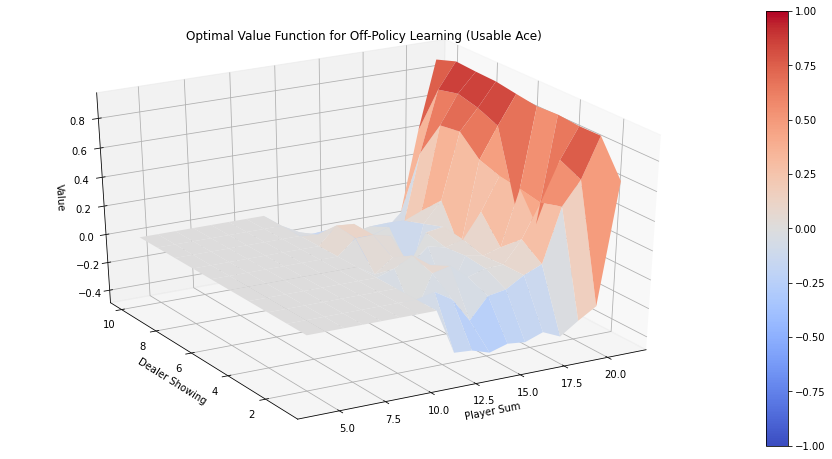

In [6]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

Off-Policy MC Learning Policy


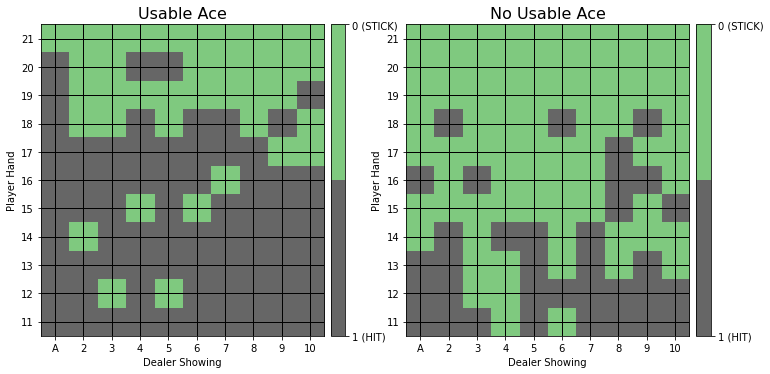

In [7]:
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
print("Off-Policy MC Learning Policy")
plot_policy(pol_test)